# Credit Card Fraud Detection

<Use Case library>

|  |  |
|--|--|
|**Title:** | Credit Card Fraud Detection |
|**Author:** | Michal Bezak, Tangent Works|
|**Industry:** | Banking  |
|**Area:** | Fraud detection  |
|**Type:** | Classification  |

## Description

Given huge volumes of payment card transactions (either debit or credit card) processed every day around the globe, to recognize *suspicious* transaction by humans is mission impossible and getting assistance by ML/AI in such use case is inevitable. 

From ML perspective such problem can be framed as *classification* problem.



## Business parameters

|  |  |
|--|--|
|**Business objective:** | Increase security of card transactions |
|**Value:** | Decrease costs associated with fraud transactions  |
|**KPI:** | Lower cost in given timeframe |

In [3]:
import logging
import pandas as pd
import plotly as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import json
import datetime

from sklearn.metrics import confusion_matrix, recall_score, precision_score
import scikitplot as skplt

import tim_client

Credentials and logging

(Do not forget to fill in your credentials in the credentials.json file)

In [4]:
with open('credentials.json') as f:
    credentials_json = json.load(f)                     # loading the credentials from credentials.json

TIM_URL = 'https://timws.tangent.works/v4/api'          # URL to which the requests are sent

SAVE_JSON = False                                       # if True - JSON requests and responses are saved to JSON_SAVING_FOLDER
JSON_SAVING_FOLDER = 'logs/'                            # folder where the requests and responses are stored

LOGGING_LEVEL = 'INFO'

In [5]:
level = logging.getLevelName(LOGGING_LEVEL)
logging.basicConfig(level=level, format='[%(levelname)s] %(asctime)s - %(name)s:%(funcName)s:%(lineno)s - %(message)s')
logger = logging.getLogger(__name__)

In [6]:
credentials = tim_client.Credentials(credentials_json['license_key'], credentials_json['email'], credentials_json['password'], tim_url=TIM_URL)
api_client = tim_client.ApiClient(credentials)

api_client.save_json = SAVE_JSON
api_client.json_saving_folder_path = JSON_SAVING_FOLDER

[INFO] 2021-02-16 09:00:27,996 - tim_client.api_client:save_json:66 - Saving JSONs functionality has been disabled
[INFO] 2021-02-16 09:00:27,997 - tim_client.api_client:json_saving_folder_path:75 - JSON destination folder changed to logs


## Dataset

The datasets contains transactions made by credit cards in September 2013 by European card holders. This dataset is highly unbalanced.

"Class" is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

### Sampling

Even though data contains timestamp sampled every second it does not represent real timestamp of transaction, in our case it serves as an "index" for each record so it can be ingested by TIM engine and properly evaluated during back-test.

### Data

| Column name| Description |Type | Availability |
|--|--|--|
|**Time**| Index in form of a timestamp | Timestamp column | |
|**Class**| Binary target (0 or 1) | Target | Sample+0 |
|**V1...V28** | Result of a PCA transformation, due to confidentiality, original features and background information about the data was not provided | Predictor |  Sample+1 |
|**Amount** | Transaction amount | Predictor | Sample+1 |

### Classification and shape of data

If we want TIM to do classification the very last record of target must be kept empty (NaN/None). TIM will use all available predictors to classify given record. Furthermore, this situation will be replicated to calculate results for all out-of-sample records during back-testing. 

Dataset was split into several CSV files that can be downloaded [here](https://download.tangent.works/sample-data/credit-card-fraud-detection/data.zip).

### Source

The original dataset has been collected by [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) and was published at [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/version/3).  


In [7]:
datasets = ['data1.csv','data2.csv','data3.csv']

data = tim_client.load_dataset_from_csv_file( datasets[2], sep=',')

In [8]:
data.tail()

Time  Class         V1         V2        V3        V4  \
94930  2012-01-19 23:08:00    0.0   2.039560  -0.175233 -1.196825  0.234580   
94931  2012-01-19 23:09:00    0.0   0.120316   0.931005 -0.546012 -0.745097   
94932  2012-01-19 23:10:00    0.0 -11.881118  10.071785 -9.834783 -2.066656   
94933  2012-01-19 23:11:00    0.0  -0.732789  -0.055080  2.035030 -0.738589   
94934  2012-01-19 23:12:00    NaN   1.919565  -0.301254 -3.249640 -0.557828   

             V5        V6        V7        V8  ...       V20       V21  \
94930 -0.008713 -0.726571  0.017050 -0.118228  ... -0.256922 -0.268048   
94931  1.130314 -0.235973  0.812722  0.115093  ...  0.000676 -0.314205   
94932 -5.364473 -2.606837 -4.918215  7.305334  ...  1.475829  0.213454   
94933  0.868229  1.058415  0.024330  0.294869  ...  0.059616  0.214205   
94934  2.630515  3.031260 -0.296827  0.708417  ...  0.001396  0.232045   

            V22       V23       V24       V25       V26       V27       V28  \
94930 -0.717211  0.297930 -0.359769 -0.315610  0.201114 -0.080826 -0.075071   
94931 -0.808520  0.050343  0.102800 -0.435870  0.124079  0.217940  0.068803   
94932  0.111864  1.014480 -0.509348  1.436807  0.250034  0.943651  0.823731   
94933  0.924384  0.012463 -1.016226 -0.606624 -0.395255  0.068472 -0.053527   
94934  0.578229 -0.037501  0.640134  0.265745 -0.087371  0.004455 -0.026561   

       Amount  
94930    2.68  
94931    2.69  
94932    0.77  
94933   24.79  
94934   67.88  

[5 rows x 31 columns]

In [9]:
data.shape

(94935, 31)

In [10]:
target_column = 'Class'

timestamp_column = 'Time'

## Engine settings

Parameters that need to be set are:

- Prediction horizon (Sample + 1) - because we want to classify the next value only.
- Back-test length.
- *allowOffsets* is set to False, and features completely disregard temporal (lagged) dictionaries, because we do not want to treat data as temporal, each record is treated independently.

We also ask for additional data from engine to see details of sub-models so we define *extendedOutputConfiguration* parameter as well.

30% of data will be used for out-of-sample interval.

In [11]:
backtest_length = int( data.shape[0] * .3 )

backtest_length

28480

In [12]:
configuration_backtest = {
    'usage': {                                 
        'predictionTo': { 
            'baseUnit': 'Sample',             
            'offset': 1                     
        },        
        'backtestLength': backtest_length 
    },
    'allowOffsets': False,
    'extendedOutputConfiguration': {
        'returnExtendedImportances': True  
    }
}

## Experiment iteration(s)

Proportion of classes for in-sample interval.

In [13]:
data.iloc[:-backtest_length][ target_column ].value_counts() 

0.0    66355
1.0      100
Name: Class, dtype: int64

Proportion of classes for out-of-sample interval.

In [14]:
data.iloc[-backtest_length:][ target_column ].value_counts() 

0.0    28457
1.0       22
Name: Class, dtype: int64

In [15]:
backtest = api_client.prediction_build_model_predict(data, configuration_backtest) 

backtest.status                                                            

'Finished'

In [18]:
backtest.result_explanations

[]

In [19]:
out_of_sample_predictions = backtest.aggregated_predictions[1]['values']          # 1 points to ouf-of-sample interval

In [20]:
out_of_sample_predictions.rename( columns = {'Prediction': target_column+'_pred'}, inplace=True)

In [21]:
out_of_sample_timestamps = out_of_sample_predictions.index.tolist()

In [22]:
evaluation_data = data.copy()

evaluation_data[ timestamp_column ] = pd.to_datetime( data[ timestamp_column ] ).dt.tz_localize('UTC')
evaluation_data = evaluation_data[ evaluation_data[ timestamp_column ].isin( out_of_sample_timestamps ) ]

evaluation_data.set_index( timestamp_column ,inplace=True)

evaluation_data = evaluation_data[ [ target_column ] ]

In [23]:
def encode_class( x ):
    if x < .5: return 0
    return 1

In [24]:
evaluation_data = evaluation_data.join( out_of_sample_predictions )

evaluation_data[ target_column+'_pred_p'  ] =  evaluation_data[ target_column+'_pred' ]
evaluation_data[ target_column+'_pred'  ] =  evaluation_data[ target_column+'_pred'  ].apply( encode_class )

evaluation_data

Class  Class_pred  Class_pred_p
Time                                                      
2011-12-31 04:32:00+00:00    0.0           0      0.000170
2011-12-31 04:33:00+00:00    0.0           0      0.002300
2011-12-31 04:34:00+00:00    0.0           0      0.003942
2011-12-31 04:35:00+00:00    0.0           0      0.002690
2011-12-31 04:36:00+00:00    0.0           0      0.000556
...                          ...         ...           ...
2012-01-19 23:07:00+00:00    0.0           0      0.002937
2012-01-19 23:08:00+00:00    0.0           0      0.000000
2012-01-19 23:09:00+00:00    0.0           0      0.000000
2012-01-19 23:10:00+00:00    0.0           0      0.000000
2012-01-19 23:11:00+00:00    0.0           0      0.000000

[28480 rows x 3 columns]

In [25]:
evaluation_data[target_column].value_counts()

0.0    28458
1.0       22
Name: Class, dtype: int64

## Insights - inspecting ML models

Simple and extended importances are available for you to see to what extent each predictor contributes in explaining variance of target variable.

In [26]:
simple_importances = backtest.predictors_importances['simpleImportances']
simple_importances = sorted(simple_importances, key = lambda i: i['importance'], reverse=True) 

simple_importances = pd.DataFrame.from_dict( simple_importances )

# simple_importances

In [27]:
fig = go.Figure()

fig.add_trace(go.Bar( x = simple_importances['predictorName'],
                      y = simple_importances['importance'] )
             )

fig.update_layout(
        title='Simple importances'
)

fig.show()

In [28]:
extended_importances = backtest.predictors_importances['extendedImportances']
extended_importances = sorted(extended_importances, key = lambda i: i['importance'], reverse=True) 

extended_importances = pd.DataFrame.from_dict( extended_importances )

#extended_importances

In [29]:
fig = go.Figure()

fig.add_trace(go.Bar( x = extended_importances[ extended_importances['time'] == '[1]' ]['termName'],
                      y = extended_importances[ extended_importances['time'] == '[1]' ]['importance'] )
             )

fig.update_layout(
        title='Features generated from predictors used by model',
        height = 700
)

fig.show()


## Evaluation of results

Results for out-of-sample interval.

### Accuracy

In [30]:
metrics_accuracy = evaluation_data[ evaluation_data[ target_column+'_pred' ] == evaluation_data[target_column]  ].shape[0] / evaluation_data.shape[0]
metrics_accuracy

[INFO] 2021-02-16 09:07:12,343 - numexpr.utils:_init_num_threads:145 - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO] 2021-02-16 09:07:12,344 - numexpr.utils:_init_num_threads:157 - NumExpr defaulting to 8 threads.


0.9996488764044944

### Confusion matrix

In [31]:
TP = evaluation_data[ ( evaluation_data[ target_column+'_pred' ] == 1 ) & ( evaluation_data[ target_column ] == 1 ) ].shape[0]
FP = evaluation_data[ ( evaluation_data[ target_column+'_pred' ] == 1 ) & ( evaluation_data[ target_column ] == 0 ) ].shape[0]
TN = evaluation_data[ ( evaluation_data[ target_column+'_pred' ] == 0 ) & ( evaluation_data[ target_column ] == 0 ) ].shape[0]
FN = evaluation_data[ ( evaluation_data[ target_column+'_pred' ] == 0 ) & ( evaluation_data[ target_column ] == 1 ) ].shape[0]

print('True positive:', TP)
print('False positive:', FP)
print('True negative:', TN)
print('False negative:', FN)

True positive: 16
False positive: 4
True negative: 28454
False negative: 6


In [32]:
cm = confusion_matrix( evaluation_data[ target_column ]  , evaluation_data[ target_column+'_pred' ]  )

cm = np.pad(cm, (1, 0), 'constant')
cm[0][2] = 1
cm[2][0] = 1

cm

array([[    0,     0,     1],
       [    0, 28454,     4],
       [    1,     6,    16]])

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

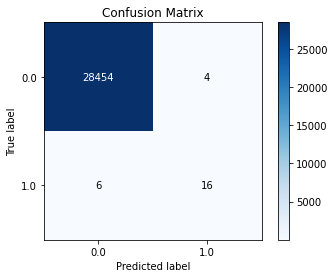

In [33]:
skplt.metrics.plot_confusion_matrix( evaluation_data[target_column], evaluation_data[target_column+'_pred'], normalize=False )

### Precision, Recall, Specificity, F1 score

Precision - proportion of positive data points that are correctly considered as positive, with respect to data points predicted as positive (both correctly and incorrectly).

Recall (true positive rate or Sensitivity) - proportion of positive data points that are correctly considered as positive, with respect to all positive data points.

Specificity (true negative rate) - proportion of negative data points that are correctly considered as negative, with respect to all negative data points.


In [34]:
metrics_precision = precision_score( evaluation_data[ target_column ] , evaluation_data[ target_column+'_pred' ]  )
metrics_precision

0.8

In [35]:
metrics_recall = recall_score( evaluation_data[ target_column ] ,  evaluation_data[ target_column+'_pred' ]  )
metrics_recall

0.7272727272727273

In [36]:
metrics_specificity = TN / ( FP + TN )
metrics_specificity

0.9998594419846791

In [37]:
metrics_f1 = 2 * (metrics_precision * metrics_recall) / (metrics_precision + metrics_recall)
metrics_f1

0.761904761904762

### Cumulative gains & Lift

*Cumulative gain* curve assesses the performance of the model and compares the results with the random pick, it shows the percentage of targets reached when considering a certain percentage of the population.

*Lift* curve indicates how many times more than average (random pick) targets are included in this group. 

Cumulative gain and Lift curves are helpful when evaluating results where organization resources are limited. We do assume that results calculated by model would need to pass human / additional step of review before action is taken.


In [38]:
evaluation_data = evaluation_data.sort_values( by=[ target_column+'_pred_p' ], ascending=False )

evaluation_data.head()

Class  Class_pred  Class_pred_p
Time                                                      
2012-01-05 00:22:00+00:00    1.0           1           1.0
2012-01-05 10:25:00+00:00    1.0           1           1.0
2012-01-08 13:23:00+00:00    1.0           1           1.0
2012-01-04 16:54:00+00:00    1.0           1           1.0
2012-01-04 12:28:00+00:00    1.0           1           1.0

In [39]:
group_size = int( evaluation_data.shape[0] / 100 )
group_size

284

In [40]:
evaluation_data['lift_group'] = 0

group_id = 1

for i in range(100):
    evaluation_data.iloc[ ( i * group_size ) : ( i * group_size + group_size ) ]['lift_group'] = group_id
    group_id += 1

In [41]:
rate_total =  evaluation_data[  evaluation_data[ target_column ] == 1 ].shape[0]  / evaluation_data.shape[0]

rate_total

0.0007724719101123596

In [42]:
lift_result = dict()

for g in range( 1,100+1 ):
    actual_positive_in_group = evaluation_data[ ( evaluation_data['lift_group'] == g ) & ( evaluation_data[ target_column ] == 1 ) ].shape[0]
    group_population_size = evaluation_data[ ( evaluation_data['lift_group'] == g ) ].shape[0]

    lift_result[g] = { 'model': None, 'baseline': None }
    lift_result[g]['model'] =  actual_positive_in_group / group_population_size / rate_total
    lift_result[g]['baseline'] =  rate_total * group_population_size

In [43]:
lift_result_df = pd.DataFrame.from_dict( lift_result, orient='index')

lift_result_df.tail()

model  baseline
96     0.0  0.219382
97     0.0  0.219382
98     0.0  0.219382
99     0.0  0.219382
100    0.0  0.219382

In [44]:
lift_result_df = lift_result_df.cumsum()

lift_result_df.tail()

model   baseline
96   100.28169  21.060674
97   100.28169  21.280056
98   100.28169  21.499438
99   100.28169  21.718820
100  100.28169  21.938202

In [45]:
fig = go.Figure()

x_values = lift_result_df.index / 100

y_values_model = lift_result_df['model'] / lift_result_df['model'].iloc[-1]
y_values_baseline = lift_result_df['baseline'] / lift_result_df['baseline'].iloc[-1]

fig.add_trace( go.Scatter( x = x_values , y = y_values_model, name = 'Model' )  )
fig.add_trace( go.Scatter( x = x_values , y = y_values_baseline, name = 'Baseline', line = dict(color='red',  dash='dot')  ) )

fig.update_layout( height = 700, width = 700, title = 'Cumulative gains chart', xaxis_title = '% of samples', yaxis_title = 'Gain' )                           

fig.show()

In [46]:
fig = go.Figure()

x_values = lift_result_df.index / 100

y_values_model = lift_result_df['model'] / lift_result_df['model'].iloc[-1]
y_values_baseline = lift_result_df['baseline'] / lift_result_df['baseline'].iloc[-1]

fig.add_trace( go.Scatter( x = x_values , y = y_values_model / y_values_baseline, name = 'Lift' )  )
fig.add_trace( go.Scatter( x = x_values , y = y_values_baseline / y_values_baseline, name = 'Baseline', line = dict(color='red',  dash='dot')  )  )

fig.update_layout( height = 700, width = 700, title = 'Lift chart', xaxis_title = '% of samples', yaxis_title = 'Lift' )                           

fig.show()

### Summary

We demonstrated how TIM can be used for classification task. With the default (math) settings, addressing imbalance of classes average recall was about 75%.

Dataset is very imbalanced, so it is recommended to address this problem by over/under sampling to further improve accuracy.

| | | |
|--|--|--|--|
| **Data file**|**Precision** | **Recall** | **Specificity** | **F1**  |
| data1.csv| 0.9729 | 0.7500  | 0.9999 | 0.8470  |
| data2.csv| 0.8462 |  0.7857 |0.9999  | 0.8148  |
| data3.csv|0.8000  |0.7272   | 0.9999 | 0.7619  |
